In [1]:
%pwd

'd:\\Advanced Project\\Lesion-Stroke-Segmentation\\notebooks'

In [2]:
import os
os.chdir("../")

In [3]:
%pwd

'd:\\Advanced Project\\Lesion-Stroke-Segmentation'

In [4]:
from pathlib import Path
from dataclasses import dataclass

In [5]:
@dataclass(frozen=True)
class DataValidationEntity:
    root_dir: Path
    animation_file: Path
    report_file: Path

In [6]:
from lesionSeg.constant import *
from lesionSeg.Utils.common import read_yaml, create_directory

In [7]:
class ConfigurationManager:
    def __init__(self, params=PARAMS_FILE_PATH, config=CONFIG_FILE_PATH):
        self.params = read_yaml(params)
        self.config = read_yaml(config)

        create_directory([self.config.artifact_root])

    def data_validation_config(self):
        config = self.config.data_validation

        create_directory([config.sample_op_dir])

        data_validation = DataValidationEntity(
            root_dir = config.root_dir,
            animation_file = config.animation_file,
            report_file = config.report_file,
        )

        return data_validation

In [8]:
from bids import BIDSLayout
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import nibabel as nib
import pandas as pd
import matplotlib as mpl
import imageio_ffmpeg
import sys
import random
from lesionSeg.logging import logger 
from lesionSeg.Exception.exception import CustomeException


ffmpeg_path = imageio_ffmpeg.get_ffmpeg_exe()
mpl.rcParams['animation.ffmpeg_path'] = ffmpeg_path


class DataValidation:
    def __init__(self, config: DataValidationEntity):
        self.config = config

    def animate_slices(self, input_data, mask_data, interval=200):
        n_slices = input_data.shape[2]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        
        slice_index = 0
        im1 = ax1.imshow(input_data[:, :, slice_index], cmap='gray', origin='lower')
        ax1.set_title(f"T1 Image (Slice {slice_index})")
        ax1.axis('off')
        
        im2 = ax2.imshow(input_data[:, :, slice_index], cmap='gray', origin='lower')
        masked_mask = np.ma.masked_equal(mask_data[:, :, slice_index], 0)
        mask_im = ax2.imshow(masked_mask, cmap='autumn', alpha=0.5, origin='lower')
        ax2.set_title(f"T1 with Lesion Mask (Slice {slice_index})")
        ax2.axis('off')
        
        def update(frame):
            im1.set_array(input_data[:, :, frame])
            ax1.set_title(f"T1 Image (Slice {frame})")
            
            im2.set_array(input_data[:, :, frame])
            masked_mask = np.ma.masked_equal(mask_data[:, :, frame], 0)
            mask_im.set_array(masked_mask)
            ax2.set_title(f"T1 with Lesion Mask (Slice {frame})")
            
            return im1, im2, mask_im
        
        ani = animation.FuncAnimation(
            fig, update, frames=range(n_slices), interval=interval, blit=False, repeat=True
        )
        
        plt.tight_layout()
        return ani
    
    
    def dataset_report(self, train, test):
        tr_len = len(train.get_subjects())
        ts_len = len(test.get_subjects())
        total = tr_len + ts_len

        df = pd.Series({
            "Training Data": tr_len,
            "Testing Data": ts_len,
            "Total Data": total,
        })

        file_dir = self.config.report_file
        df.to_csv(file_dir)
        logger.info(f"Dataset Report: {file_dir}")

        

    def load_nii_file(self, file_path):
        img = nib.load(file_path)
        data = img.get_fdata()
        return data

    def load_dataset(self):
        root_dir = self.config.root_dir
        try:
            training_layout = BIDSLayout(root=f"{root_dir}/Training", validate=False)
            testing_layout = BIDSLayout(root=f"{root_dir}/Testing", validate=False)

            logger.info(f"Total Training Data: {len(training_layout.get_subjects())}")
            logger.info(f"Total Testing Data: {len(testing_layout.get_subjects())}")

            logger.info(f"Extracting a Sample Input and Output Data")

            rand_number = random.randint(a=0, b=654)

            input_sample = training_layout.get(suffix='T1w', extension=['.nii', '.nii.gz'])[rand_number]
            output_sample = training_layout.get(suffix='mask', extension=['.nii', '.nii.gz'])[rand_number]

            logger.info(f"Loading Sample Input: {input_sample}")
            logger.info(f"Loading Sample Output: {output_sample}")

            input_data = self.load_nii_file(input_sample)
            mask_data = self.load_nii_file(output_sample)

            ani = self.animate_slices(input_data, mask_data, interval=200)

            Writer = animation.writers['ffmpeg']
            writer = Writer(fps=5, metadata=dict(artist='abc'), bitrate=1800)

            sample_dir = self.config.animation_file

            ani.save(sample_dir, writer=writer)
            logger.info(f"Saved the sample data at: {sample_dir}")

            self.dataset_report(training_layout, testing_layout)
        except Exception as e:
            raise CustomeException(e,sys)


[2025-02-05 03:33:55,864]: INFO: common : Read YAML File: params.yaml
[2025-02-05 03:33:55,876]: INFO: common : Read YAML File: config\config.yaml
[2025-02-05 03:33:55,878]: INFO: common : Directory has been Created: artifact
[2025-02-05 03:33:55,879]: INFO: common : Directory has been Created: artifact\data_validation
[2025-02-05 03:34:05,781]: INFO: 3133882004 : Total Training Data: 655
[2025-02-05 03:34:06,105]: INFO: 3133882004 : Total Testing Data: 300
[2025-02-05 03:34:06,106]: INFO: 3133882004 : Extracting a Sample Input and Output Data
[2025-02-05 03:34:06,157]: INFO: 3133882004 : Loading Sample Input: <BIDSImageFile filename='d:\Advanced Project\Lesion-Stroke-Segmentation\artifact\data_ingestion\Training\R049\sub-r049s012\ses-1\anat\sub-r049s012_ses-1_space-MNI152NLin2009aSym_T1w.nii.gz'>
[2025-02-05 03:34:06,158]: INFO: 3133882004 : Loading Sample Output: <BIDSImageFile filename='d:\Advanced Project\Lesion-Stroke-Segmentation\artifact\data_ingestion\Training\R049\sub-r049s012

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


[2025-02-05 03:34:06,400]: INFO: batteryrunners : pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
[2025-02-05 03:34:06,842]: INFO: animation : Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
[2025-02-05 03:34:06,846]: INFO: animation : MovieWriter._run: running command: 'd:\Advanced Project\Lesion-Stroke-Segmentation\env\Lib\site-packages\imageio_ffmpeg\binaries\ffmpeg-win-x86_64-v7.1.exe' -f rawvideo -vcodec rawvideo -s 1000x500 -pix_fmt rgba -framerate 5 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -b 1800k -metadata artist=abc -y artifact/data_validation/mri_animation.mp4
[2025-02-05 03:35:10,406]: INFO: 3133882004 : Saved the sample data at: artifact/data_validation/mri_animation.mp4
[2025-02-05 03:35:11,642]: INFO: 3133882004 : Dataset Report: artifact/data_validation/report.csv


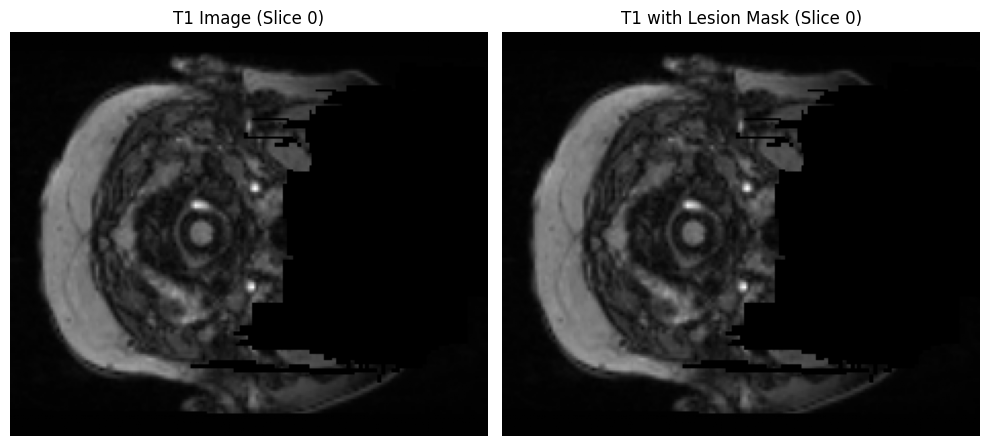

In [9]:
try:
    config = ConfigurationManager()
    data_validation_config = config.data_validation_config()
    data_validation = DataValidation(data_validation_config)
    data_validation.load_dataset()
except Exception as e:
    e

In [10]:
tr_path = "artifact/data_ingestion/Training"
tr = BIDSLayout(tr_path, validate=False)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\ehtes\AppData\Local\Temp\ipykernel_19384\2533154018.py:1: SyntaxWarning: invalid escape sequence '\d'
  tr_path = "artifact\data_ingestion\Training"


In [72]:
remove_cols = ["extension", "session", "space", "suffix","datatype"]

In [73]:
df = tr.to_df()

In [74]:
df["data_type"] = "training"

In [75]:
t1w_df = df[df['suffix']=='T1w'].drop(remove_cols, axis = 1)
t1w_df = t1w_df.rename({'path': "input_path"}, axis=1)

entity,input_path,subject,data_type
1,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s001,training
3,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s002,training
5,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s003,training
7,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s004,training
9,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s005,training
...,...,...,...
1333,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s026,training
1335,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s027,training
1337,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s029,training
1339,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s031,training


In [ ]:
mask_df = df[df['suffix']=='mask'].drop(remove_cols, axis = 1)
mask_df = mask_df.rename({'path': 'output_path'}, axis =1)

entity,output_path,subject,data_type
2,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s001,training
4,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s002,training
6,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s003,training
8,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s004,training
10,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s005,training
...,...,...,...
1334,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s026,training
1336,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s027,training
1338,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s029,training
1340,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s031,training


In [77]:
df_merge = t1w_df.merge(mask_df, on=['subject', 'data_type'])
df_merge

entity,input_path,subject,data_type,output_path
0,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s001,training,d:\Advanced Project\Lesion-Stroke-Segmentation...
1,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s002,training,d:\Advanced Project\Lesion-Stroke-Segmentation...
2,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s003,training,d:\Advanced Project\Lesion-Stroke-Segmentation...
3,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s004,training,d:\Advanced Project\Lesion-Stroke-Segmentation...
4,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s005,training,d:\Advanced Project\Lesion-Stroke-Segmentation...
...,...,...,...,...
650,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s026,training,d:\Advanced Project\Lesion-Stroke-Segmentation...
651,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s027,training,d:\Advanced Project\Lesion-Stroke-Segmentation...
652,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s029,training,d:\Advanced Project\Lesion-Stroke-Segmentation...
653,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s031,training,d:\Advanced Project\Lesion-Stroke-Segmentation...


In [78]:
ts_path = "artifact/data_ingestion/Testing"
ts = BIDSLayout(ts_path, validate=False)

In [79]:
df_ts = ts.to_df()

In [80]:
df_ts = df_ts[df_ts["suffix"]=='T1w'].drop(remove_cols, axis=1)
df_ts["data_type"] = "testing"
df_ts = df_ts.rename({'path': 'input_path'}, axis=1)

In [81]:
df_ts

entity,input_path,subject,data_type
1,d:\Advanced Project\Lesion-Stroke-Segmentation...,r005s016,testing
2,d:\Advanced Project\Lesion-Stroke-Segmentation...,r005s025,testing
3,d:\Advanced Project\Lesion-Stroke-Segmentation...,r005s030,testing
4,d:\Advanced Project\Lesion-Stroke-Segmentation...,r005s034,testing
5,d:\Advanced Project\Lesion-Stroke-Segmentation...,r005s044,testing
...,...,...,...
319,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s024,testing
320,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s028,testing
321,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s030,testing
322,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s033,testing


In [82]:
import pandas as pd

In [83]:
pd_conc = pd.concat([df_merge, df_ts], axis=0)
pd_conc

entity,input_path,subject,data_type,output_path
0,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s001,training,d:\Advanced Project\Lesion-Stroke-Segmentation...
1,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s002,training,d:\Advanced Project\Lesion-Stroke-Segmentation...
2,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s003,training,d:\Advanced Project\Lesion-Stroke-Segmentation...
3,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s004,training,d:\Advanced Project\Lesion-Stroke-Segmentation...
4,d:\Advanced Project\Lesion-Stroke-Segmentation...,r001s005,training,d:\Advanced Project\Lesion-Stroke-Segmentation...
...,...,...,...,...
319,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s024,testing,NaN
320,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s028,testing,NaN
321,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s030,testing,NaN
322,d:\Advanced Project\Lesion-Stroke-Segmentation...,r052s033,testing,NaN
